In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Colab").config('spark.ui.port','4050').getOrCreate()
spark

In [ ]:
df = spark.read.format("csv").load("kenya_agricultural_data.csv", header= True, inferSchema=True)
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Region: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_Celsius: double (nullable = true)
 |-- Humidity_Percent: double (nullable = true)
 |-- Soil_Moisture_Percent: double (nullable = true)
 |-- Water_Retention: double (nullable = true)
 |-- Soil_Fertility: double (nullable = true)
 |-- Soil_Drainage: double (nullable = true)
 |-- Crop_Health_Index: double (nullable = true)
 |-- Altitude_Range: string (nullable = true)



We show our dataset

In [ ]:
df.show(3000)

+----------+-----------------+------+---------+------+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+
|      Date|           Region|County|Soil_Type|  Crop|Rainfall_mm|Temperature_Celsius|Humidity_Percent|Soil_Moisture_Percent|Water_Retention|Soil_Fertility|Soil_Drainage|Crop_Health_Index|Altitude_Range|
+----------+-----------------+------+---------+------+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+
|2019-01-01|Central Highlands| Nyeri| Nitisols|   Tea|       32.4|               17.3|            64.5|                 37.6|            0.8|           0.9|         0.85|             62.8|    1500-2500m|
|2019-01-02|Central Highlands| Nyeri| Nitisols|   Tea|       98.5|               10.7|            61.4|                 80.7|            0.8|           0.9|         0.85|             7

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
df = df.withColumn('id', monotonically_increasing_id())
df = df[['id'] + df.columns[:-1]]
df.show(3000)

+----+----------+-----------------+------+---------+------+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+
|  id|      Date|           Region|County|Soil_Type|  Crop|Rainfall_mm|Temperature_Celsius|Humidity_Percent|Soil_Moisture_Percent|Water_Retention|Soil_Fertility|Soil_Drainage|Crop_Health_Index|Altitude_Range|
+----+----------+-----------------+------+---------+------+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+
|   0|2019-01-01|Central Highlands| Nyeri| Nitisols|   Tea|       32.4|               17.3|            64.5|                 37.6|            0.8|           0.9|         0.85|             62.8|    1500-2500m|
|   1|2019-01-02|Central Highlands| Nyeri| Nitisols|   Tea|       98.5|               10.7|            61.4|                 80.7|            0.8|           0.9|   

Lets slice the dates and perform drought analysis on them

In [ ]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date

df = df.withColumn('Date', to_date(df['Date'], 'dd/MM/yyyy'))
df = df.withColumn('Month_Date', date_format(df['Date'], 'dd/MM'))
df.show(10)

+---+----------+-----------------+------+---------+----+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+----------+
| id|      Date|           Region|County|Soil_Type|Crop|Rainfall_mm|Temperature_Celsius|Humidity_Percent|Soil_Moisture_Percent|Water_Retention|Soil_Fertility|Soil_Drainage|Crop_Health_Index|Altitude_Range|Month_Date|
+---+----------+-----------------+------+---------+----+-----------+-------------------+----------------+---------------------+---------------+--------------+-------------+-----------------+--------------+----------+
|  0|2019-01-01|Central Highlands| Nyeri| Nitisols| Tea|       32.4|               17.3|            64.5|                 37.6|            0.8|           0.9|         0.85|             62.8|    1500-2500m|     01/01|
|  1|2019-01-02|Central Highlands| Nyeri| Nitisols| Tea|       98.5|               10.7|            61.4|                 80.7|     

Lets create a desired table showing all the missing months

In [ ]:
missing_month = df.select('Month_Date').distinct()
missing_month.show(100)

+----------+
|Month_Date|
+----------+
|     06/07|
|     14/10|
|     27/01|
|     11/05|
|     12/04|
|     11/02|
|     21/03|
|     15/11|
|     05/07|
|     06/11|
|     08/03|
|     03/05|
|     22/07|
|     05/11|
|     04/01|
|     02/02|
|     27/03|
|     05/12|
|     03/03|
|     19/11|
|     04/03|
|     26/10|
|     17/11|
|     08/12|
|     19/08|
|     04/10|
|     16/09|
|     12/07|
|     09/03|
|     20/10|
|     15/01|
|     28/06|
|     07/05|
|     19/09|
|     10/11|
|     17/07|
|     31/08|
|     14/12|
|     17/02|
|     10/06|
|     28/10|
|     19/01|
|     10/03|
|     29/06|
|     27/08|
|     07/11|
|     20/02|
|     10/07|
|     28/12|
|     28/04|
|     19/07|
|     09/09|
|     03/02|
|     18/08|
|     30/09|
|     01/05|
|     01/04|
|     16/07|
|     13/12|
|     17/03|
|     21/02|
|     13/03|
|     03/04|
|     30/11|
|     30/03|
|     29/05|
|     02/04|
|     06/12|
|     12/01|
|     06/04|
|     10/04|
|     02/08|
|     19/10|
|     16/12|

Lets create a new dataset for the desired columns

In [ ]:
new_df = df.select("id","Month_Date", "Temperature_Celsius", "Rainfall_mm", "Soil_Moisture_Percent", "Crop","Region")
new_df.show(10)

+---+----------+-------------------+-----------+---------------------+----+-----------------+
| id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent|Crop|           Region|
+---+----------+-------------------+-----------+---------------------+----+-----------------+
|  0|     01/01|               17.3|       32.4|                 37.6| Tea|Central Highlands|
|  1|     02/01|               10.7|       98.5|                 80.7| Tea|Central Highlands|
|  2|     03/01|               23.6|       53.1|                 49.5| Tea|Central Highlands|
|  3|     04/01|               13.0|       25.5|                 29.6| Tea|Central Highlands|
|  4|     05/01|               11.7|       26.4|                 30.2| Tea|Central Highlands|
|  5|     06/01|               19.5|       98.0|                 79.5| Tea|Central Highlands|
|  6|     07/01|               15.3|       49.8|                 47.2| Tea|Central Highlands|
|  7|     08/01|               18.3|       49.6|            

In [ ]:
# prompt: I want to find out whether the region of western kenya has months of 3,4,5, 10,11,12 and to display if any and check whether they have any crop attached to them

from pyspark.sql.functions import col

# Filter the DataFrame for the Western Kenya region
western_kenya_df = new_df.filter(col("Region") == "Western Kenya")

# Extract the month from the Month_Date column
western_kenya_df = western_kenya_df.withColumn("Month", date_format(to_date(col("Month_Date"), "dd/MM"), "MM"))

# Filter for the desired months
desired_months_df = western_kenya_df.filter(col("Month").isin(["03", "04", "05", "10", "11", "12"]))

# Check if there are any records for the desired months
if desired_months_df.count() > 0:
  print("Western Kenya has data for the months of March, April, May, October, November, and December.")

  # Check if there are any crops associated with these months
  if desired_months_df.filter(col("Crop").isNotNull()).count() > 0:
    print("There are crops associated with these months in Western Kenya.")
    desired_months_df.select("Month", "Crop").distinct().show()
  else:
    print("There are no crops associated with these months in Western Kenya.")

else:
  print("Western Kenya does not have data for the months of March, April, May, October, November, and December.")


Western Kenya has data for the months of March, April, May, October, November, and December.
There are crops associated with these months in Western Kenya.
+-----+--------------+
|Month|          Crop|
+-----+--------------+
|   04|         Maize|
|   10|     Sugarcane|
|   04|Sweet Potatoes|
|   10|Sweet Potatoes|
|   12|Sweet Potatoes|
|   10|         Maize|
|   12|         Beans|
|   03|     Sugarcane|
|   03|         Beans|
|   11|     Sugarcane|
|   05|     Sugarcane|
|   05|         Maize|
|   12|     Sugarcane|
|   03|Sweet Potatoes|
|   10|         Beans|
|   11|         Beans|
|   11|         Maize|
|   05|         Beans|
|   03|         Maize|
|   12|         Maize|
+-----+--------------+
only showing top 20 rows



In [ ]:
averages_df = new_df.select('Rainfall_mm','Soil_Moisture_Percent','Temperature_Celsius').agg({'Rainfall_mm':'avg',
                                                                            'Soil_Moisture_Percent':'avg',
                                                                            'Temperature_Celsius':'avg'})

In [ ]:
unique_Crops = new_df.select('Crop').distinct()
unique_Crops.show()
unique_Crops.count()

+--------------+
|          Crop|
+--------------+
|      Potatoes|
|           Tea|
|       Sorghum|
|         Beans|
|         Maize|
|     Sugarcane|
|       Cowpeas|
|         Wheat|
|        Coffee|
|Sweet Potatoes|
|        Millet|
|     Pyrethrum|
|    Cashewnuts|
|       Mangoes|
|       Cassava|
|      Coconuts|
|   Green Grams|
+--------------+



17

Lets create a threshold for drought conditions

In [ ]:
drought_thresholds = {
    'Rainfall_mm': 30,
    'Soil_Moisture_Percent': 20,
    'Temperature_Celsius': 25
}
drought_thresholds

{'Rainfall_mm': 30, 'Soil_Moisture_Percent': 20, 'Temperature_Celsius': 25}

Lets assign drought conditions to one or zero for drought status

In [ ]:
unique_regions = new_df.select('Region').distinct()
unique_regions.show()

+-----------------+
|           Region|
+-----------------+
|      Rift Valley|
|    Western Kenya|
|Central Highlands|
|          Eastern|
|            Coast|
+-----------------+



In [ ]:
avg_values = averages_df.collect()[0]
avg_rainfall = avg_values[0]
avg_soil_moisture = avg_values[1]
avg_temperature =  avg_values[2]

In [ ]:
drought_condition = (
    avg_rainfall < drought_thresholds['Rainfall_mm'] and
    avg_soil_moisture < drought_thresholds['Soil_Moisture_Percent'] and
    avg_temperature > drought_thresholds['Temperature_Celsius']
)

In [ ]:
from pyspark.sql.functions import when,col
def calculate_drought_status(new_df):
    return new_df.withColumn(
        'Drought_Status',
        when(
            (col('Rainfall_mm') < drought_thresholds['Rainfall_mm']) &
            (col('Soil_Moisture_Percent') < drought_thresholds['Soil_Moisture_Percent']) &
            (col('Temperature_Celsius') > drought_thresholds['Temperature_Celsius']),
            1
        ).otherwise(0)
    )

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

class DroughtStatusCalculator(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol=None, outputCol=None):
        super(DroughtStatusCalculator, self).__init__()
        # Initialize parameters if needed

    def _transform(self, new_df):
        return calculate_drought_status(new_df)

In [ ]:
new_df.filter(col("Temperature_Celsius")> 25).show()

+-----+----------+-------------------+-----------+---------------------+-----+-------------+
|   id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent| Crop|       Region|
+-----+----------+-------------------+-----------+---------------------+-----+-------------+
|73084|     05/01|               28.4|       44.8|                 38.8|Maize|Western Kenya|
|73086|     07/01|               30.8|       28.1|                 28.3|Maize|Western Kenya|
|73088|     09/01|               27.9|       17.2|                 22.9|Maize|Western Kenya|
|73089|     10/01|               26.6|       81.8|                 54.5|Maize|Western Kenya|
|73090|     11/01|               26.4|       23.2|                 28.1|Maize|Western Kenya|
|73093|     14/01|               28.1|       10.8|                 20.6|Maize|Western Kenya|
|73095|     16/01|               30.5|       79.3|                 54.9|Maize|Western Kenya|
|73098|     19/01|               25.2|       33.6|                 31.

In [ ]:
train, test = new_df.randomSplit([0.7, 0.3])
train, test

(DataFrame[id: bigint, Month_Date: string, Temperature_Celsius: double, Rainfall_mm: double, Soil_Moisture_Percent: double, Crop: string, Region: string],
 DataFrame[id: bigint, Month_Date: string, Temperature_Celsius: double, Rainfall_mm: double, Soil_Moisture_Percent: double, Crop: string, Region: string])

In [ ]:
unique_soil_type = new_df.select('Region').distinct()
unique_soil_type.show()

+-----------------+
|           Region|
+-----------------+
|      Rift Valley|
|    Western Kenya|
|Central Highlands|
|          Eastern|
|            Coast|
+-----------------+



In [ ]:
numerical_features_lst = train.columns
numerical_features_lst.remove('Month_Date')
numerical_features_lst.remove('Crop')
numerical_features_lst.remove('id')
numerical_features_lst.remove('Region')

numerical_features_lst

['Temperature_Celsius', 'Rainfall_mm', 'Soil_Moisture_Percent']

In [ ]:
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F
imputer = Imputer(inputCols=numerical_features_lst,
                  outputCols=numerical_features_lst
                  )
imputer = imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)
train = train.withColumn(
    'Drought_Status',
    F.when(
        (F.col('Rainfall_mm')< drought_thresholds['Rainfall_mm']) &
        (F.col('Soil_Moisture_Percent')< drought_thresholds['Soil_Moisture_Percent']) &
        (F.col('Temperature_Celsius')> drought_thresholds['Temperature_Celsius']),
    1
    ).otherwise(0)
)
test = test.withColumn(
    'Drought_Status',
    F.when(
        (F.col('Rainfall_mm')< drought_thresholds['Rainfall_mm']) &
        (F.col('Soil_Moisture_Percent')< drought_thresholds['Soil_Moisture_Percent']) &
        (F.col('Temperature_Celsius')> drought_thresholds['Temperature_Celsius']),
    1
    ).otherwise(0)
)

print('Training with drought status')
train.show(1200)
print('Testing with drought status')
test.show(1200)

Training with drought status
+----+----------+-------------------+-----------+---------------------+----+-----------------+--------------+
|  id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent|Crop|           Region|Drought_Status|
+----+----------+-------------------+-----------+---------------------+----+-----------------+--------------+
|   0|     01/01|               17.3|       32.4|                 37.6| Tea|Central Highlands|             0|
|   1|     02/01|               10.7|       98.5|                 80.7| Tea|Central Highlands|             0|
|   3|     04/01|               13.0|       25.5|                 29.6| Tea|Central Highlands|             0|
|   4|     05/01|               11.7|       26.4|                 30.2| Tea|Central Highlands|             0|
|   5|     06/01|               19.5|       98.0|                 79.5| Tea|Central Highlands|             0|
|   6|     07/01|               15.3|       49.8|                 47.2| Tea|Central Highlan

In [ ]:
from pyspark.ml.feature import StringIndexer

crop_indexer = StringIndexer(inputCol='Crop', outputCol='Crop_Indexer', handleInvalid='keep')
region_indexer = StringIndexer(inputCol='Region', outputCol='Region_Indexer',handleInvalid='keep')

crop_indexer_model = crop_indexer.fit(train)
region_indexer_model = region_indexer.fit(train)

train = crop_indexer_model.transform(train)
train = region_indexer_model.transform(train)
test = crop_indexer_model.transform(test)
test = region_indexer_model.transform(test)


In [ ]:
from pyspark.ml.feature import OneHotEncoder
crop_encoder = OneHotEncoder(inputCol="Crop_Indexer", outputCol="Crop_Encoded")
region_encoder = OneHotEncoder(inputCol="Region_Indexer", outputCol="Region_Encoded")
#Fit and transform the train data
crop_encoder_model = crop_encoder.fit(train)
train = crop_encoder_model.transform(train)
region_encoder_model = region_encoder.fit(train)
train = region_encoder_model.transform(train)

In [ ]:
test = crop_encoder_model.transform(test)
test = region_encoder_model.transform(test)

In [ ]:
train.show(100)

+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+
| id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent|Crop|           Region|Drought_Status|Crop_Indexer|Region_Indexer|   Crop_Encoded|Region_Encoded|
+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+
|  0|     01/01|               17.3|       32.4|                 37.6| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],[1.0])|
|  1|     02/01|               10.7|       98.5|                 80.7| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],[1.0])|
|  3|     04/01|               13.0|       25.5|                 29.6| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],

In [ ]:
test.show(100)

+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+
| id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent|Crop|           Region|Drought_Status|Crop_Indexer|Region_Indexer|   Crop_Encoded|Region_Encoded|
+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+
|  2|     03/01|               23.6|       53.1|                 49.5| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],[1.0])|
|  8|     09/01|               10.8|       96.4|                 78.7| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],[1.0])|
| 11|     12/01|               16.8|       65.1|                 56.5| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],

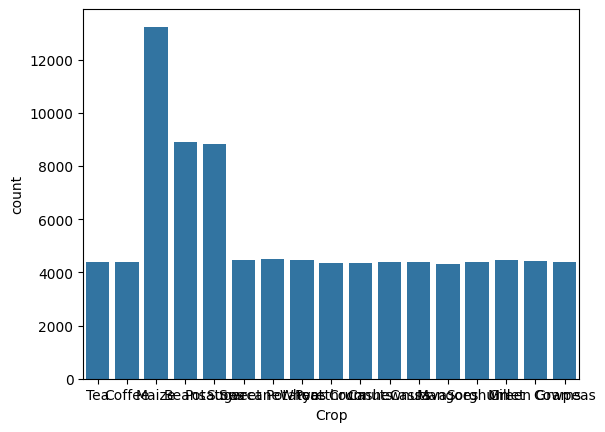

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = test.toPandas()
sns.countplot(x="Crop", data=pandas_df)
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
features_columns = ['Rainfall_mm', 'Soil_Moisture_Percent', 'Temperature_Celsius', 'Crop_Encoded', 'Region_Encoded']
assembler = VectorAssembler(inputCols=features_columns, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [ ]:
train.select('features').take(10)

[Row(features=SparseVector(25, {0: 32.4, 1: 37.6, 2: 17.3, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 98.5, 1: 80.7, 2: 10.7, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 25.5, 1: 29.6, 2: 13.0, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 26.4, 1: 30.2, 2: 11.7, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 98.0, 1: 79.5, 2: 19.5, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 49.8, 1: 47.2, 2: 15.3, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 49.6, 1: 49.1, 2: 18.3, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 37.2, 1: 38.5, 2: 21.7, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 7.8, 1: 18.5, 2: 16.2, 13: 1.0, 20: 1.0})),
 Row(features=SparseVector(25, {0: 24.6, 1: 31.3, 2: 17.8, 13: 1.0, 20: 1.0}))]

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='Drought_Status')
lr_model = lr.fit(train)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Drought_Status')
rf_model = rf.fit(train)

In [ ]:
lr_predictions = lr_model.transform(test)
rf_predictions = rf_model.transform(test)

In [ ]:
lr_predictions.show(200)
rf_predictions.show(3000)

+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+--------------------+--------------------+
| id|Month_Date|Temperature_Celsius|Rainfall_mm|Soil_Moisture_Percent|Crop|           Region|Drought_Status|Crop_Indexer|Region_Indexer|   Crop_Encoded|Region_Encoded|            features|          prediction|
+---+----------+-------------------+-----------+---------------------+----+-----------------+--------------+------------+--------------+---------------+--------------+--------------------+--------------------+
|  2|     03/01|               23.6|       53.1|                 49.5| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],[1.0])|(25,[0,1,2,13,20]...| 0.07177298738029224|
|  8|     09/01|               10.8|       96.4|                 78.7| Tea|Central Highlands|             0|        10.0|           0.0|(17,[10],[1.0])| (5,[0],

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Drought_Status', predictionCol='prediction',metricName='rmse')
lr_rmse = evaluator.evaluate(lr_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")


Linear Regression RMSE: 0.18321326859091172
Random Forest RMSE: 0.041254127507942724


So we choose randomForest algorithm

In [ ]:
from pyspark.ml import Pipeline
drought_status_calculator = DroughtStatusCalculator(inputCol='features', outputCol='Drought_Status')
pipeline = Pipeline(stages=[crop_indexer, region_indexer,crop_encoder,region_encoder, drought_status_calculator, assembler, rf])
rf_model = pipeline.fit(df)

Lets save model in pickle format in Mongodb

We save our RandomForest Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/My Drive/New_Prediction_Model_02'
rf_model.save(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from pyspark.ml import PipelineModel
loaded_model = PipelineModel.load(model_path)

In [ ]:
new_data = spark.createDataFrame(
    [(14,19,56,"Potatoes","Western Kenya")],
    ['Rainfall_mm','Soil_Moisture_Percent','Temperature_Celsius','Crop','Region']
)
prediction = loaded_model.transform(new_data)

In [ ]:
prediction.select('Drought_Status', 'Prediction').show()

+--------------+------------------+
|Drought_Status|        Prediction|
+--------------+------------------+
|             1|0.5037808948378641|
+--------------+------------------+



In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Log the input data and predictions using print
print(f"Input Data: {new_data}")
print(f"Predicted Drought Status: {prediction.select('Drought_status','Prediction')}")

Input Data: DataFrame[Rainfall_mm: double, Soil_Moisture_Percent: bigint, Temperature_Celsius: bigint, Crop: string, Region: string]
Predicted Drought Status: DataFrame[Drought_status: int, Prediction: double]
